In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import pandas as pd
import torch
import re
import ocr_parser
import DateCleaner


In [202]:
from fuzzywuzzy import fuzz

In [ ]:
userData = pd.read_csv('Bill.com/Users.csv')
userData 

In [213]:
test1 = 'this is the longer sentence with no errors'
test2 = 'this is sentece n errors'

check = fuzz.ratio(test1,test2)

check

73

In [ ]:
#Get dataframe of dataframes containing OCR files 
OCR_files = ocr_parser.parse_files()
OCR_files

In [50]:
#GET CLEAN DATES FROM OCR DATA
mapping = DateCleaner.get_reformatted_strings()
date_df = DateCleaner.create_pd_df(mapping)


In [ ]:
#Take all important features of userData and put into set to prepare for scoring function
userData_sets = []
for row in range(userData.shape[0]):
    temp = set(userData.loc[row, 'vendor_name'].split())
    temp2 = temp.union(set(userData.loc[row, 'vendor_address'].replace('.','').replace(',','AttributeError').split()))
    # temp3 = temp2.union(set((userData.loc[row, 'amount'].astype(str) + ' ' + userData.loc[row,'date']).split()))
    temp3 = temp2.union(set(userData.loc[row, 'amount'].astype(str)))
    userData_sets.append(temp3)
    
userData_sets


In [361]:
#LOAD IN PRICES FROM OCR AND USERDATA
ocr_prices = 
userData_prices = userData.amount
userData_prices

0        72.90
1        43.90
2        32.23
3       503.10
4      1110.00
        ...   
494      29.30
495       8.70
496       2.50
497      63.80
498       5.88
Name: amount, Length: 499, dtype: float64

In [ ]:
#LOAD IN COORDINATE DATA FOR USER DATA AND OCR

user_locations = pd.read_csv("user_data_coords.csv", index_col="Address")[["Latitude", "Longitude"]]
ocr_locations = pd.read_csv("ocr_coords.csv", index_col="Document")[["Latitude", "Longitude", "Header", "Location"]]

In [368]:
testa = [13, 42, 13, 91,29]
testa = np.array(testa)
testing = np.where(testa == 13)[0] * 2
testing[0]


0

In [359]:
#TRYING LEVENSHTEIN DISTANCE FOR DATES

#SCORE BY SIMILARITY/MATCHES

#Put all text in receipt in a set 
def get_receipt_text(OCR):
    step1 = OCR.loc[:, 'TEXT'].astype(str).tolist()
    step2 = ' '.join(step1)
    OCR_set = set(step2.replace('(','').replace(')','').replace('.','').split())
    return OCR_set

#Calculate the similarity scores between receipt and each of the listings
#DOESN'T ACTUALLY ONLY SCORE -- ALSO FINDS INDEX 
def scoring_func(userData_prices, userData_dates, OCR_set, date, user_locations, ocr_locations, fileCode):
    # scores_text = []
    scores_date = []
    scores_price = []
    for row in range(len(userData_dates)):
        #Look for matching dates
        if (date != None):
            match_dates = max(fuzz.ratio(date[0],userData_dates[row]), fuzz.ratio(date[1], userData_dates[row]))
        else:
            match_dates = 0     #Might need to change?
        scores_date.append(match_dates)
        
        #Look for matching price amounts
        if (price != None): 
            match_prices = max(fuzz.ratio(price, userData_prices[row]))
        else: 
            match_prices = 0
        scores_price.append(match_prices)
        
    scores_date = np.array(scores_date)
    if(len(np.where(scores_date == 100)[0]) == 1):
        return np.where(scores_date == 100)[0][0]      #NOTE -- COULD IDENTIFY INCORRECTLY IF OCR MISTAKE LEADS TO A 
                                #WRONG BUT EXISTING DATE 
    # if(len(np.where(scores_date == 100)[0]) > 1):
    #     right_dates = np.where(scores_date == 100)
    
    
    else: 
        #Add distance measurement
        distances = []
        for row in range(len(userData_dates)):
            addressUsed = userData.iloc[row].vendor_address
            user_coords = user_locations.loc[addressUsed].values
            ocr_coords = ocr_locations.loc[fileCode].values
            readability = user_coords[0:1] - ocr_coords[0:1]
            distances.append(np.dot(readability, readability))

        distances = np.array(distances)  
        # print('second check')  
        # print(distances)
        distances = np.nan_to_num(distances, nan = np.inf)
        # return (np.argmin(distances))
        
        
        return np.argmax(scores_date * 1/(distances+0.001))       #NOTE -- COULD IDENTIFY INCORRECTLY IF OCR MISTAKE LEADS TO A 
                                                #WRONG BUT EXISTING DATE
                                                

#display the listing with the strongest match
def find_paymentID(userData, scores):
    return userData.iloc[np.argmax(scores)].paymentid
def find_paymentID2(userData, score_loc):
    return userData.iloc[score_loc].paymentid

In [358]:
#TESTING ACCURACY 
correct = 0
counter = 0
wrongIDs = []
wrongDates = []
wrong_guesses = []
for fileCode in OCR_files.keys():                                       #filecode from OCR
    OCR = OCR_files[fileCode]
    OCR_set = get_receipt_text(OCR)
    # temp = date_df[date_df['Document ID'] == fileCode]
    date = date_df[date_df['Document ID'] == fileCode].iloc[0].Dates    #date from OCR
    scores = scoring_func(userData_sets, userData_dates,OCR_set, date, user_locations, ocr_locations, fileCode)
    # print(scores)
    payment_ID = find_paymentID2(userData, scores)
    # payment_ID = find_paymentID(userData, scores)            #finds index of highest match and 
                                                             #returns the associated paymentID
    # guessed_documentID = find_paymentID(userData, scores)
    # print(payment_ID)
    # print(userData.paymentid)
    guessed_docID = userData[userData.paymentid == payment_ID].iloc[0].documentid
    
    counter += 1
    if(fileCode == guessed_docID):
        correct += 1 
    else: 
        wrongIDs.append(fileCode)
        wrongDates.append(date)
        wrong_guesses.append(guessed_docID)
        

print(correct/counter)

100
0.4804270462633452


In [116]:
check1 = df_check[df_check['Wrong IDs'] == '00d0608126101'].iloc[0]['Wrong Dates']
print(check1)
location = userData[userData.documentid == '00d0608126101'].index
location
match_dates = int(check1[0] == userData_dates[location]) + int(check1[1] == userData_dates[location])
match_dates

['2018-4-17', '2018-17-4']


1

In [342]:
len(wrong_guesses)

361

In [ ]:
#CHECK ONE

#Get date from OCR 
filecode = '00d0102367243'
OCR_all_dates = date_df.Dates
date = OCR_all_dates[4]
# print(date)

#Get text from OCR
OCR = OCR_files[filecode]
OCR_set = get_receipt_text(OCR)
userData_dates = userData.date

#Find matches between OCR data and user data, then guess docID
scores = scoring_func(userData_sets, userData_dates, OCR_set, date)
payment_ID = find_paymentID(userData, scores)
guessed_docID = userData[userData.paymentid == payment_ID].iloc[0].documentid
print(guessed_docID)
correct_docID = pd.read_csv('new_formatted.csv')['Document ID']
print(userData[userData.documentid == guessed_docID])
userData[userData.paymentid == payment_ID]

In [343]:
# wrong_guess_dates = 
p = {'Wrong IDs': wrongIDs, 'Wrong Dates': wrongDates, 'Wrong Guesses': wrong_guesses}
df_check = pd.DataFrame(data=p)
df_check

,Wrong IDs,Wrong Dates,Wrong Guesses
0,00d0815885891,"[2018-4-16, 2018-16-4]",00d0981184214
1,00d0797433528,"[None, None]",00d0243046961
2,00d0508747957,"[2018-4-3, 2018-3-4]",00d0191077139
3,00d0188523936,"[2017-5-10, 2017-10-5]",00d0194076657
4,00d0675832982,"[2018-3-20, 2018-20-3]",00d0799986048
...,...,...,...
356,00d0389135415,"[2018-3-12, 2018-12-3]",00d0243046961
357,00d0453489586,"[2018-4-22, 2018-22-4]",00d0267909555
358,00d0314913072,"[2017-2-9, 2017-9-2]",00d0674219107
359,00d0292723088,"[2018-3-2, 2018-2-3]",00d0624439175


In [340]:
date_from_id = df_check.iloc[4]['Wrong Dates']
date_from_id
correct_date = userData[userData.documentid == '00d0675832982'].iloc[0].date
print(correct_date)
max(fuzz.ratio(date_from_id[0], correct_date), fuzz.ratio(date_from_id[1], correct_date))

2018-3-20


100

Only dates: 0.32028 
Only text: 0.32562
Both: 0.32562

In [118]:
len(OCR_files)

562

In [224]:
#OLD METHOD

#SCORE BY SIMILARITY/MATCHES

#Put all text in receipt in a set 
def get_receipt_text(OCR):
    step1 = OCR.loc[:, 'TEXT'].astype(str).tolist()
    step2 = ' '.join(step1)
    OCR_set = set(step2.replace('(','').replace(')','').replace('.','').split())
    return OCR_set

#Calculate the similarity scores between receipt and each of the listings
def scoring_func(userData_sets, userData_dates, OCR_set, date, user_locations, ocr_locations, fileCode):
    # scores_text = []
    scores_date = []
    score_counter = 0
    for row in range(len(userData_dates)):
        #Look for matching dates
        if (date != None):
            match_dates = int(date[0] == userData_dates[row]) + int(date[1] == userData_dates[row])
        else:
            match_dates = 0     #Change? 
        scores_date.append(match_dates)
        
    if(sum(scores_date) == 1):
        return scores_date      #NOTE -- COULD IDENTIFY INCORRECTLY IF OCR MISTAKE LEADS TO A 
                                #WRONG BUT EXISTING DATE 
    
    else: 
        #Add distance measurement
        distances = []
        for row in range(len(userData_dates)):
            addressUsed = userData.iloc[row].vendor_address
            user_coords = user_locations.loc[addressUsed].values
            ocr_coords = ocr_locations.loc[fileCode].values
            distances.append(np.dot(user_coords[0:1] - ocr_coords[0:1:],user_coords[0:1] - ocr_coords[0:1]))
       
        distances = np.array(distances)    
        return (scores_date * 1/(distances+0.001) * 10)        #NOTE -- COULD IDENTIFY INCORRECTLY IF OCR MISTAKE LEADS TO A 
                                                #WRONG BUT EXISTING DATE
              
    # overlap_text = len(userData_sets[row].intersection(OCR_set))
    # scores_text.append(overlap_text)
    
    # print(scores_date)

    return(0 *scores_text + 1*scores_date)

#display the listing with the strongest match
def find_paymentID(userData, scores):
    return userData.iloc[np.argmax(scores)].paymentid

In [52]:
y = date_df.Dates.apply(lambda lst: tuple(lst) if lst and lst[0] else None).values
print(len(y))
print(len(set(y)))

x = date_df.Dates.apply(lambda lst: sorted(lst)[0] if lst and lst[0] else None).values
print(len(x))
print(len(set(x)))

562
286


In [ ]:
for r in range(len(OCR)):
    print(OCR.iloc[r].TEXT)

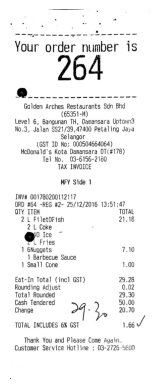

In [90]:
image = Image.open("Bill.com/img/00d0223498663.jpg")
image = np.array(image)
plt.imshow(image); plt.axis(False);

In [ ]:
OCR_strings = panda
for row in range(OCR.shape()):
    strings = {}
    strings.add(OCR.amount, OCR.date, OCR.vendor_name, OCR.vendor_address)
    OCR_strings


In [112]:
# test_file = open("test.txt", 'r')
# text = test_file.read()
# dates = re.findall('(\d+/\d+/\d+)', text)
# OCR_STRING = OCR.applymap(str)
OCR_STRING = OCR.to_string()
date_re = "\d{2}[/-]\d{2}[/-]\d{4}"
dates = re.findall(date_re, OCR_STRING)